# ***Model 1***

In [ ]:
# ============================================================================
# SETUP AND IMPORTS
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
import warnings
import gc  # Garbage collector for memory management
warnings.filterwarnings('ignore')

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU Available: []


In [ ]:
# ============================================================================
# MEMORY OPTIMIZATION: Use smaller data sample
# ============================================================================

# For Colab free tier, we'll use a subset of data
USE_FULL_DATASET = False  # Set to True if you have Colab Pro
SAMPLE_SIZE = 100000  # Use first 100k samples (~70 days of data)

Loading dataset...
Using first 100000 samples to conserve memory

=== DATASET OVERVIEW ===
Shape: (100000, 15)
Memory usage: 17.17 MB
Target variable: T (degC)


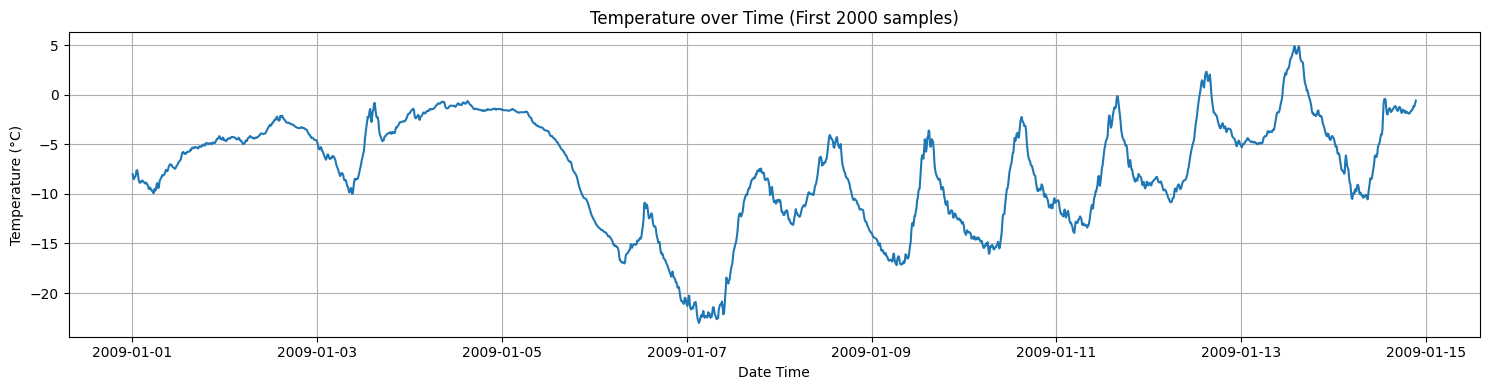

In [ ]:
# ============================================================================
# DATA LOADING AND EXPLORATION
# ============================================================================

url = 'jena_climate_2009_2016.csv'
print("Loading dataset...")

if USE_FULL_DATASET:
    df = pd.read_csv(url)
else:
    # Memory optimization: Load only subset
    df = pd.read_csv(url, nrows=SAMPLE_SIZE)
    print(f"Using first {SAMPLE_SIZE} samples to conserve memory")

print(f"\n=== DATASET OVERVIEW ===")
print(f"Shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Convert date-time and set as index
df['Date Time'] = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')
df = df.set_index('Date Time')

# Select target
target_col = 'T (degC)'
print(f"Target variable: {target_col}")

# Visualize target (smaller sample)
plt.figure(figsize=(15, 4))
plt.plot(df.index[:2000], df[target_col][:2000])
plt.title('Temperature over Time (First 2000 samples)')
plt.xlabel('Date Time')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# ============================================================================
# FEATURE ENGINEERING AND SCALING
# ============================================================================

print("\n=== SCALING DATA ===")
scaler = StandardScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df),
    columns=df.columns,
    index=df.index
)

# Clear original dataframe to save memory
del df
gc.collect()


=== SCALING DATA ===


3125

In [ ]:
# ============================================================================
# MEMORY-EFFICIENT DATA GENERATOR
# ============================================================================

class TimeSeriesGenerator(keras.utils.Sequence):
    """
    Memory-efficient data generator that creates batches on-the-fly
    instead of storing all sequences in memory.
    """
    def __init__(self, data, target_idx, seq_length, batch_size,
                 start_idx=0, end_idx=None, shuffle=False):
        self.data = data
        self.target_idx = target_idx
        self.seq_length = seq_length
        self.batch_size = batch_size
        self.start_idx = start_idx
        self.end_idx = end_idx if end_idx else len(data) - seq_length - 1
        self.shuffle = shuffle
        self.indices = np.arange(self.start_idx, self.end_idx)

        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        """Number of batches per epoch"""
        return (self.end_idx - self.start_idx) // self.batch_size

    def __getitem__(self, idx):
        """Generate one batch of data"""
        # Get batch indices
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]

        # Generate batch
        X_batch = np.zeros((len(batch_indices), self.seq_length, self.data.shape[1]))
        y_batch = np.zeros((len(batch_indices), 1))

        for i, seq_idx in enumerate(batch_indices):
            X_batch[i] = self.data.iloc[seq_idx:seq_idx + self.seq_length].values
            y_batch[i] = self.data.iloc[seq_idx + self.seq_length, self.target_idx]

        return X_batch, y_batch

    def on_epoch_end(self):
        """Shuffle indices after each epoch"""
        if self.shuffle:
            np.random.shuffle(self.indices)

In [ ]:
# ============================================================================
# PREPARE DATA GENERATORS
# ============================================================================

SEQ_LENGTH = 72  # Reduced from 144 to 72 (12 hours) for memory efficiency
BATCH_SIZE = 128  # Reduced batch size
target_idx = df_scaled.columns.get_loc(target_col)

print(f"\n=== SEQUENCE CONFIGURATION ===")
print(f"Sequence length: {SEQ_LENGTH} timesteps ({SEQ_LENGTH * 10} minutes)")
print(f"Batch size: {BATCH_SIZE}")

# Calculate split indices
n_samples = len(df_scaled) - SEQ_LENGTH - 1
train_size = int(0.7 * n_samples)
val_size = int(0.15 * n_samples)

print(f"\n=== DATA SPLIT ===")
print(f"Train: {train_size} samples ({train_size/n_samples*100:.1f}%)")
print(f"Validation: {val_size} samples ({val_size/n_samples*100:.1f}%)")
print(f"Test: {n_samples - train_size - val_size} samples")

# Create generators
train_gen = TimeSeriesGenerator(
    df_scaled, target_idx, SEQ_LENGTH, BATCH_SIZE,
    start_idx=0, end_idx=train_size, shuffle=True
)

val_gen = TimeSeriesGenerator(
    df_scaled, target_idx, SEQ_LENGTH, BATCH_SIZE,
    start_idx=train_size, end_idx=train_size + val_size, shuffle=False
)

test_gen = TimeSeriesGenerator(
    df_scaled, target_idx, SEQ_LENGTH, BATCH_SIZE,
    start_idx=train_size + val_size, shuffle=False
)

print(f"Train batches: {len(train_gen)}")
print(f"Validation batches: {len(val_gen)}")
print(f"Test batches: {len(test_gen)}")


=== SEQUENCE CONFIGURATION ===
Sequence length: 72 timesteps (720 minutes)
Batch size: 128

=== DATA SPLIT ===
Train: 69948 samples (70.0%)
Validation: 14989 samples (15.0%)
Test: 14990 samples
Train batches: 546
Validation batches: 117
Test batches: 117


In [ ]:
# ============================================================================
# OPTIMIZED MODEL ARCHITECTURE
# ============================================================================

def build_lstm_model(seq_length, n_features, lstm_units=[64, 32], dropout_rate=0.2):
    """
    Build an optimized LSTM model with reduced units for memory efficiency.

    ARCHITECTURAL CHOICES:
    1. Reduced LSTM units (64, 32) to lower memory footprint
    2. Single dropout layer to save memory
    3. Batch normalization for stable training
    """
    model = keras.Sequential([
        layers.LSTM(lstm_units[0], return_sequences=True,
                   input_shape=(seq_length, n_features)),
        layers.Dropout(dropout_rate),
        layers.LSTM(lstm_units[1], return_sequences=False),
        layers.Dropout(dropout_rate),
        layers.Dense(1)
    ], name='Jena_LSTM_Optimized')

    # Use mixed precision for memory efficiency on GPU
    if len(tf.config.list_physical_devices('GPU')) > 0:
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss='mse',
            metrics=['mae']
        )
    else:
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss='mse',
            metrics=['mae']
        )

    return model

# Build model
model = build_lstm_model(SEQ_LENGTH, df_scaled.shape[1])

print("\n=== MODEL ARCHITECTURE ===")
model.summary()


=== MODEL ARCHITECTURE ===


Model: "Jena_LSTM_Optimized"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 72, 64)         │        20,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 72, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,673 (127.63 KB)

 Trainable params: 32,673 (127.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# ============================================================================
# TRAINING CONFIGURATION
# ============================================================================

# Reduced callbacks for memory
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=8,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=4,
        min_lr=1e-6,
        verbose=1
    )
]

In [ ]:
# ============================================================================
# MODEL TRAINING
# ============================================================================

print("\n=== TRAINING MODEL ===")
EPOCHS = 30  # Reduced epochs

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

# Clear memory
gc.collect()


=== TRAINING MODEL ===
Epoch 1/30
546/546 ━━━━━━━━━━━━━━━━━━━━ 99s 175ms/step - loss: 0.0635 - mae: 0.1598 - val_loss: 0.0058 - val_mae: 0.0534 - learning_rate: 0.0010
Epoch 2/30
546/546 ━━━━━━━━━━━━━━━━━━━━ 94s 172ms/step - loss: 0.0142 - mae: 0.0863 - val_loss: 0.0066 - val_mae: 0.0599 - learning_rate: 0.0010
Epoch 3/30
546/546 ━━━━━━━━━━━━━━━━━━━━ 96s 175ms/step - loss: 0.0123 - mae: 0.0790 - val_loss: 0.0027 - val_mae: 0.0355 - learning_rate: 0.0010
Epoch 4/30
546/546 ━━━━━━━━━━━━━━━━━━━━ 94s 173ms/step - loss: 0.0119 - mae: 0.0772 - val_loss: 0.0047 - val_mae: 0.0511 - learning_rate: 0.0010
Epoch 5/30
546/546 ━━━━━━━━━━━━━━━━━━━━ 94s 173ms/step - loss: 0.0111 - mae: 0.0741 - val_loss: 0.0022 - val_mae: 0.0324 - learning_rate: 0.0010
Epoch 6/30
546/546 ━━━━━━━━━━━━━━━━━━━━ 94s 172ms/step - loss: 0.0108 - mae: 0.0734 - val_loss: 0.0040 - val_mae: 0.0454 - learning_rate: 0.0010
Epoch 7/30
546/546 ━━━━━━━━━━━━━━━━━━━━ 98s 180ms/step - loss: 0.0107 - mae: 0.0721 - val_loss: 0.0019 - v

778

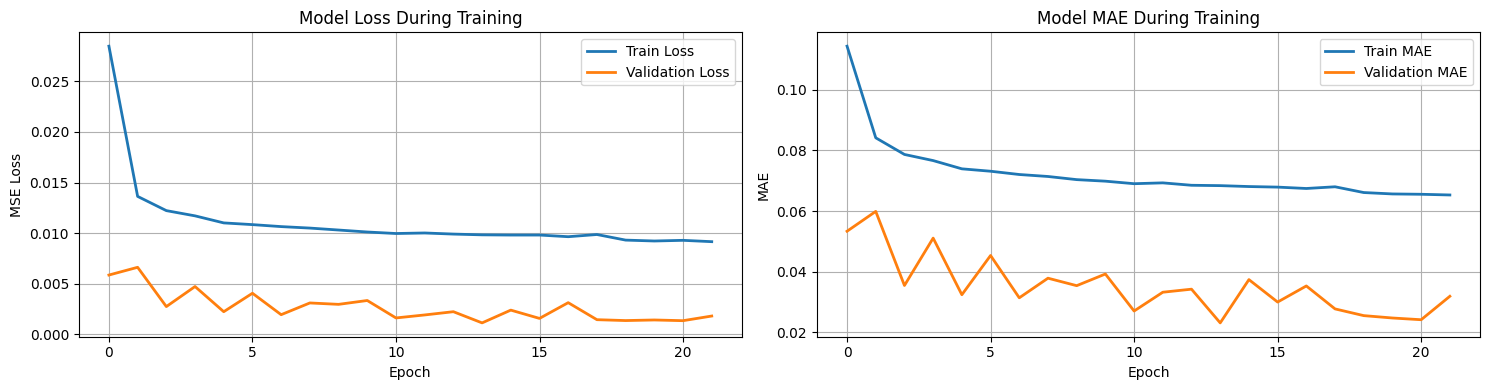

In [ ]:
# ============================================================================
# TRAINING VISUALIZATION
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(15, 4))

axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE Loss')
axes[0].set_title('Model Loss During Training')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(history.history['mae'], label='Train MAE', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].set_title('Model MAE During Training')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# ============================================================================
# MODEL EVALUATION (MEMORY-EFFICIENT)
# ============================================================================

print("\n=== MODEL EVALUATION ===")

# Evaluate on test set
test_loss, test_mae = model.evaluate(test_gen, verbose=1)
print(f"Test Loss (MSE): {test_loss:.6f}")
print(f"Test MAE: {test_mae:.6f}")

# Generate predictions in batches to save memory
print("\nGenerating predictions...")
y_pred_list = []
y_true_list = []

for i in range(len(test_gen)):
    X_batch, y_batch = test_gen[i]
    pred_batch = model.predict(X_batch, verbose=0)
    y_pred_list.append(pred_batch)
    y_true_list.append(y_batch)

    # Clear memory periodically
    if i % 10 == 0:
        gc.collect()

y_pred = np.concatenate(y_pred_list, axis=0)
y_test = np.concatenate(y_true_list, axis=0)

# Inverse transform (only target column)
dummy_pred = np.zeros((len(y_pred), df_scaled.shape[1]))
dummy_pred[:, target_idx] = y_pred.flatten()
y_pred_actual = scaler.inverse_transform(dummy_pred)[:, target_idx]

dummy_true = np.zeros((len(y_test), df_scaled.shape[1]))
dummy_true[:, target_idx] = y_test.flatten()
y_test_actual = scaler.inverse_transform(dummy_true)[:, target_idx]

# Calculate metrics
mae_actual = np.mean(np.abs(y_test_actual - y_pred_actual))
rmse_actual = np.sqrt(np.mean((y_test_actual - y_pred_actual) ** 2))

print(f"\nActual Temperature Metrics:")
print(f"MAE: {mae_actual:.4f} °C")
print(f"RMSE: {rmse_actual:.4f} °C")


=== MODEL EVALUATION ===
117/117 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 6.7790e-04 - mae: 0.0181
Test Loss (MSE): 0.000590
Test MAE: 0.017225

Generating predictions...

Actual Temperature Metrics:
MAE: 0.1494 °C
RMSE: 0.2108 °C


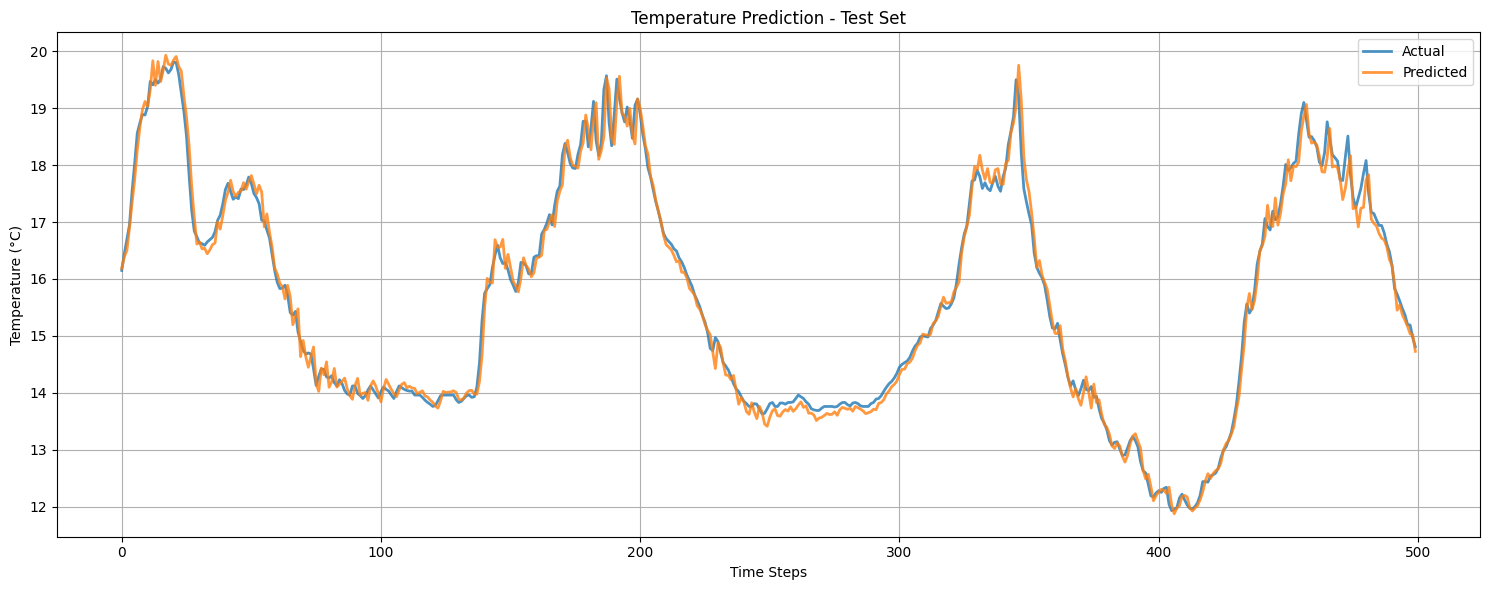

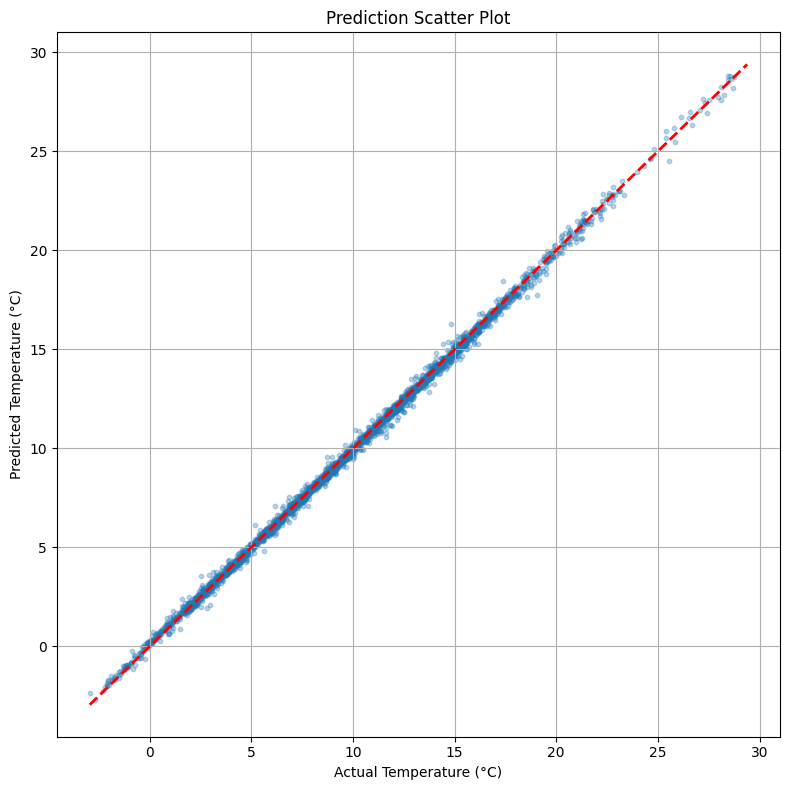

In [ ]:
# ============================================================================
# PREDICTION VISUALIZATION
# ============================================================================

n_plot = 500
plt.figure(figsize=(15, 6))
plt.plot(y_test_actual[:n_plot], label='Actual', linewidth=2, alpha=0.8)
plt.plot(y_pred_actual[:n_plot], label='Predicted', linewidth=2, alpha=0.8)
plt.xlabel('Time Steps')
plt.ylabel('Temperature (°C)')
plt.title(f'Temperature Prediction - Test Set')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(y_test_actual[::5], y_pred_actual[::5], alpha=0.3, s=10)
plt.plot([y_test_actual.min(), y_test_actual.max()],
         [y_test_actual.min(), y_test_actual.max()],
         'r--', linewidth=2)
plt.xlabel('Actual Temperature (°C)')
plt.ylabel('Predicted Temperature (°C)')
plt.title('Prediction Scatter Plot')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# ============================================================================
# QUICK HYPERPARAMETER EXPERIMENT (OPTIONAL)
# ============================================================================

print("Note: Testing 2 configurations to conserve memory")

configs = [
    {'name': 'Baseline', 'lstm_units': [64, 32], 'dropout': 0.2},
    {'name': 'Higher Dropout', 'lstm_units': [64, 32], 'dropout': 0.3},
]

results = []

for config in configs:
    print(f"\n=== Testing {config['name']} ===")

    # Clear memory
    keras.backend.clear_session()
    gc.collect()

    exp_model = build_lstm_model(
        SEQ_LENGTH,
        df_scaled.shape[1],
        lstm_units=config['lstm_units'],
        dropout_rate=config['dropout']
    )

    exp_history = exp_model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=15,
        callbacks=[
            keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=5,
                restore_best_weights=True,
                verbose=0
            )
        ],
        verbose=0
    )

    test_loss, test_mae = exp_model.evaluate(test_gen, verbose=0)

    results.append({
        'Config': config['name'],
        'Val Loss': min(exp_history.history['val_loss']),
        'Test MAE': test_mae
    })

    print(f"Test MAE: {test_mae:.6f}")

results_df = pd.DataFrame(results)
print("\n=== RESULTS ===")
print(results_df.to_string(index=False))


QUICK HYPERPARAMETER EXPERIMENTS
Note: Testing 2 configurations to conserve memory

=== Testing Baseline ===
Test MAE: 0.021345

=== Testing Higher Dropout ===
Test MAE: 0.018938

=== RESULTS ===
        Config  Val Loss  Test MAE
      Baseline  0.001398  0.021345
Higher Dropout  0.001601  0.018938


In [ ]:
# ============================================================================
# SAVE MODEL
# ============================================================================

print("\n=== SAVING MODEL ===")
model.save('jena_lstm_model.keras')
print("Model saved as 'jena_lstm_model.keras'")

print("\nMemory Optimization Strategies Used:")
print("1. Data generators instead of loading all sequences in memory")
print("2. Reduced sequence length (72 vs 144 timesteps)")
print("3. Smaller LSTM units (64, 32 vs 128, 64)")
print("4. Reduced batch size (128 vs 256)")
print("5. Subset of data (100k samples) - set USE_FULL_DATASET=True for full data")
print("6. Garbage collection after major operations")
print("7. Batch-wise prediction to avoid memory spikes")
print("\nFor full dataset: Upgrade to Colab Pro or use smaller batches/sequences")


=== SAVING MODEL ===
Model saved as 'jena_lstm_model.keras'

Memory Optimization Strategies Used:
1. Data generators instead of loading all sequences in memory
2. Reduced sequence length (72 vs 144 timesteps)
3. Smaller LSTM units (64, 32 vs 128, 64)
4. Reduced batch size (128 vs 256)
5. Subset of data (100k samples) - set USE_FULL_DATASET=True for full data
6. Garbage collection after major operations
7. Batch-wise prediction to avoid memory spikes

For full dataset: Upgrade to Colab Pro or use smaller batches/sequences


# ***Model 2***

In [ ]:
# 1. SETUP AND IMPORTS
# ============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow Version: 2.19.0
GPU Available: []


In [ ]:
# 2. DATA LOADING
# ============================================================================

# Download the dataset
url = 'jena_climate_2009_2016.csv'
data = pd.read_csv(url)

print(f"\nDataset Shape: {data.shape}")
print(f"Columns: {list(data.columns)}")
print(f"\nFirst few rows:")
print(data.head())

# Check for missing values
print(f"\nMissing Values:\n{data.isnull().sum()}")


Dataset Shape: (420551, 15)
Columns: ['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)', 'wd (deg)']

First few rows:
             Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
0  01.01.2009 00:10:00    996.52     -8.02    265.40        -8.90    93.3   
1  01.01.2009 00:20:00    996.57     -8.41    265.01        -9.28    93.4   
2  01.01.2009 00:30:00    996.53     -8.51    264.91        -9.31    93.9   
3  01.01.2009 00:40:00    996.51     -8.31    265.12        -9.07    94.2   
4  01.01.2009 00:50:00    996.51     -8.27    265.15        -9.04    94.1   

   VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  \
0          3.33          3.11          0.22       1.94             3.12   
1          3.23          3.02          0.21       1.89             3.03   
2          3.21          3.01          0.20  


Statistical Summary:
            p (mbar)       T (degC)       Tpot (K)    Tdew (degC)  \
count  420551.000000  420551.000000  420551.000000  420551.000000   
mean      989.212776       9.450147     283.492743       4.955854   
std         8.358481       8.423365       8.504471       6.730674   
min       913.600000     -23.010000     250.600000     -25.010000   
25%       984.200000       3.360000     277.430000       0.240000   
50%       989.580000       9.420000     283.470000       5.220000   
75%       994.720000      15.470000     289.530000      10.070000   
max      1015.350000      37.280000     311.340000      23.110000   

              rh (%)   VPmax (mbar)   VPact (mbar)   VPdef (mbar)  \
count  420551.000000  420551.000000  420551.000000  420551.000000   
mean       76.008259      13.576251       9.533756       4.042412   
std        16.476175       7.739020       4.184164       4.896851   
min        12.950000       0.950000       0.790000       0.000000   
25%        

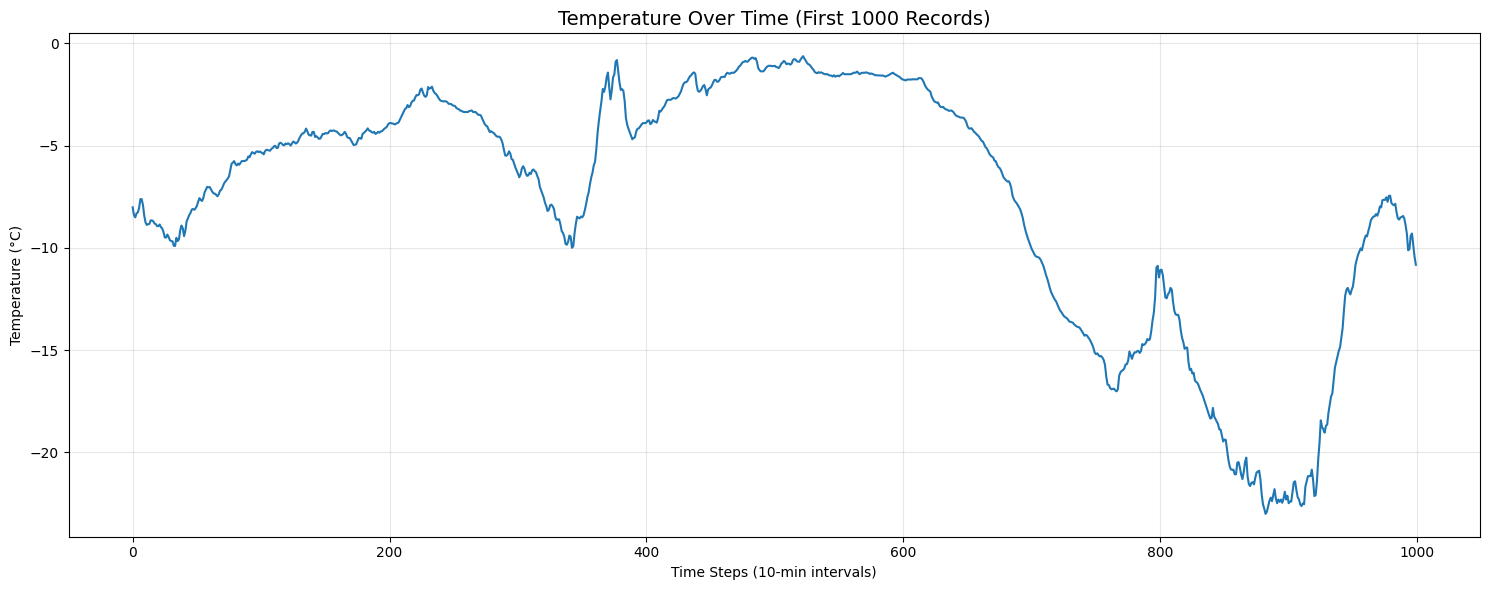

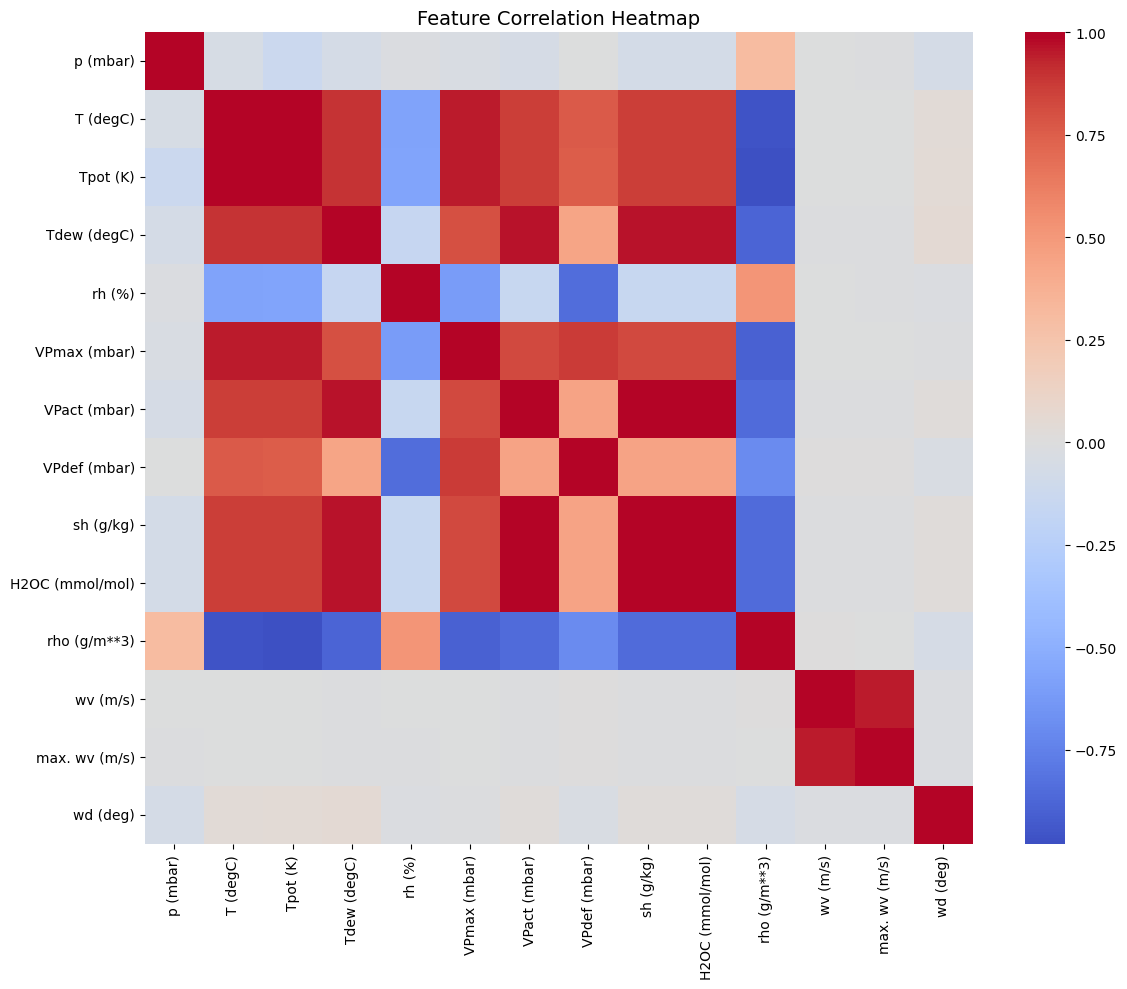

In [ ]:
# 3. EXPLORATORY DATA ANALYSIS
# ============================================================================

# Statistical summary
print("\nStatistical Summary:")
print(data.describe())

# Visualize temperature over time
plt.figure(figsize=(15, 6))
plt.plot(data['T (degC)'][:1000])
plt.title('Temperature Over Time (First 1000 Records)', fontsize=14)
plt.xlabel('Time Steps (10-min intervals)')
plt.ylabel('Temperature (°C)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 10))
correlation = data.iloc[:, 1:].corr()
sns.heatmap(correlation, annot=False, cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# 4. DATA PREPROCESSING
# ============================================================================

# Select features for modeling
# Using all weather features to predict temperature
features = data.columns[1:]  # All columns except 'Date Time'
target_column = 'T (degC)'

print(f"\nFeatures used: {list(features)}")
print(f"Target variable: {target_column}")

# Extract feature data
df = data[features].values.astype('float32')

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

print(f"\nScaled data shape: {scaled_data.shape}")
print(f"Value range after scaling: [{scaled_data.min():.4f}, {scaled_data.max():.4f}]")


Features used: ['p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)', 'wd (deg)']
Target variable: T (degC)

Scaled data shape: (420551, 14)
Value range after scaling: [0.0000, 1.0000]


In [ ]:
# 5. CREATE SEQUENCES FOR LSTM
# ============================================================================

def create_sequences(data, lookback=72, forecast_horizon=1):
    """
    Create sequences for LSTM training
    lookback: number of past timesteps to use (72 = 12 hours at 10-min intervals)
    forecast_horizon: number of future timesteps to predict
    """
    X, y = [], []
    for i in range(lookback, len(data) - forecast_horizon + 1):
        X.append(data[i-lookback:i, :])  # All features
        # Target: temperature index (assuming T (degC) is first after Date Time, so index 0 in features)
        temp_idx = list(features).index(target_column)
        y.append(data[i + forecast_horizon - 1, temp_idx])
    return np.array(X), np.array(y)

# Parameters
LOOKBACK = 72  # Use past 12 hours (72 * 10 min)
FORECAST_HORIZON = 6  # Predict 1 hour ahead (6 * 10 min)

X, y = create_sequences(scaled_data, LOOKBACK, FORECAST_HORIZON)

print(f"\nSequence creation complete:")
print(f"X shape: {X.shape} (samples, timesteps, features)")
print(f"y shape: {y.shape} (samples,)")


Sequence creation complete:
X shape: (420474, 72, 14) (samples, timesteps, features)
y shape: (420474,) (samples,)


In [ ]:
# 6. TRAIN-VALIDATION-TEST SPLIT
# ============================================================================

# Split ratios: 70% train, 15% validation, 15% test
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size + val_size]
y_val = y[train_size:train_size + val_size]

X_test = X[train_size + val_size:]
y_test = y[train_size + val_size:]

print(f"\nTrain set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")


Train set: 294331 samples
Validation set: 63071 samples
Test set: 63072 samples


In [ ]:
# 7. BUILD LSTM MODEL
# ============================================================================

def build_lstm_model(input_shape):
    """Build a multi-layer LSTM model"""
    model = Sequential([
        # First LSTM layer with return sequences
        LSTM(128, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),

        # Second LSTM layer with return sequences
        LSTM(64, return_sequences=True),
        Dropout(0.2),

        # Third LSTM layer
        LSTM(32, return_sequences=False),
        Dropout(0.2),

        # Dense layers
        Dense(16, activation='relu'),
        Dense(1)
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )

    return model

# Build the model
model = build_lstm_model((LOOKBACK, X_train.shape[2]))

print("\nModel Architecture:")
model.summary()


Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 72, 128)        │        73,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 72, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 72, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 72, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 135,585 (529.63 KB)

 Trainable params: 135,585 (529.63 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# 8. TRAIN THE MODEL
# ============================================================================

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# Train the model
print("\nStarting training...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=25,
    batch_size=256,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("\nTraining complete!")


Starting training...
Epoch 1/25
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 784s 681ms/step - loss: 2.2641e-04 - mae: 0.0109 - val_loss: 0.0029 - val_mae: 0.0473 - learning_rate: 2.5000e-04
Epoch 2/25
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 792s 673ms/step - loss: 2.1025e-04 - mae: 0.0104 - val_loss: 0.0026 - val_mae: 0.0454 - learning_rate: 2.5000e-04
Epoch 3/25
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 776s 675ms/step - loss: 2.0120e-04 - mae: 0.0102 - val_loss: 0.0027 - val_mae: 0.0464 - learning_rate: 2.5000e-04
Epoch 4/25
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 779s 677ms/step - loss: 1.9555e-04 - mae: 0.0100 - val_loss: 0.0025 - val_mae: 0.0445 - learning_rate: 2.5000e-04
Epoch 5/25
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 776s 654ms/step - loss: 1.9270e-04 - mae: 0.0099 - val_loss: 0.0033 - val_mae: 0.0502 - learning_rate: 2.5000e-04
Epoch 6/25
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 799s 652ms/step - loss: 1.9328e-04 - mae: 0.0099 - val_loss: 0.0027 - val_mae: 0.0463 - learning_rate: 2.5000e-04
Epoch 7/25
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 

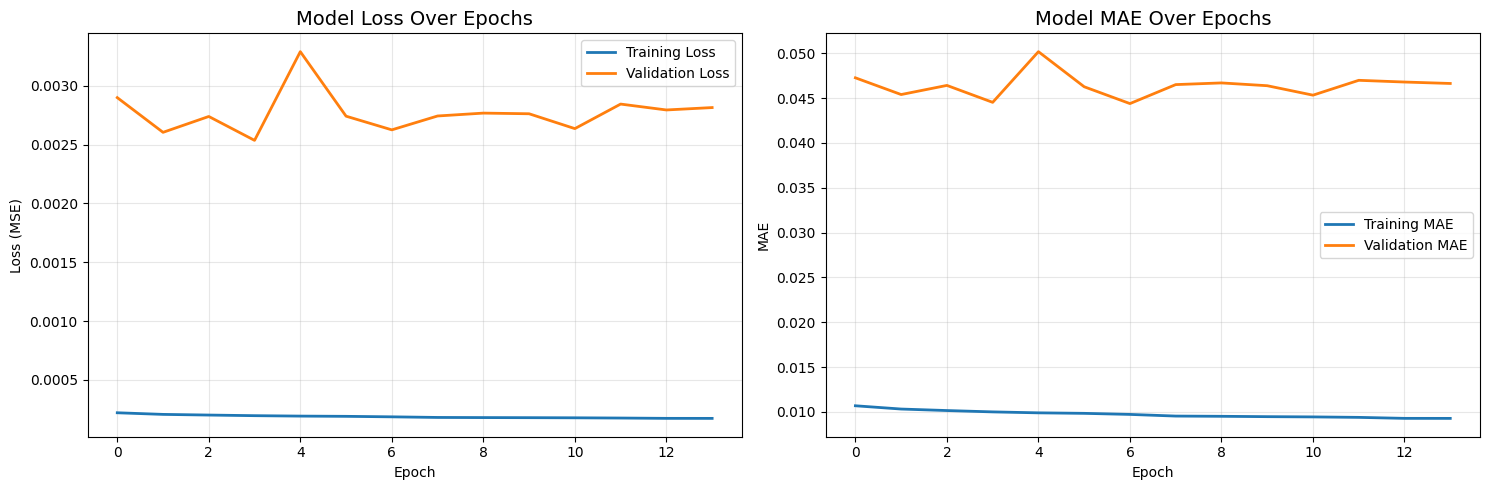

In [14]:
# 9. VISUALIZE TRAINING HISTORY
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss
axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_title('Model Loss Over Epochs', fontsize=14)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# MAE
axes[1].plot(history.history['mae'], label='Training MAE', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
axes[1].set_title('Model MAE Over Epochs', fontsize=14)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [15]:
# 10. MODEL EVALUATION
# ============================================================================

# Make predictions
y_train_pred = model.predict(X_train, verbose=0)
y_val_pred = model.predict(X_val, verbose=0)
y_test_pred = model.predict(X_test, verbose=0)

# Function to denormalize temperature predictions
def denormalize_temp(scaled_values, scaler, temp_idx):
    """Denormalize temperature values back to original scale"""
    dummy = np.zeros((len(scaled_values), scaler.n_features_in_))
    dummy[:, temp_idx] = scaled_values.flatten()
    denormalized = scaler.inverse_transform(dummy)
    return denormalized[:, temp_idx]

temp_idx = list(features).index(target_column)

# Denormalize predictions and actual values
y_train_actual = denormalize_temp(y_train.reshape(-1, 1), scaler, temp_idx)
y_train_predicted = denormalize_temp(y_train_pred, scaler, temp_idx)

y_val_actual = denormalize_temp(y_val.reshape(-1, 1), scaler, temp_idx)
y_val_predicted = denormalize_temp(y_val_pred, scaler, temp_idx)

y_test_actual = denormalize_temp(y_test.reshape(-1, 1), scaler, temp_idx)
y_test_predicted = denormalize_temp(y_test_pred, scaler, temp_idx)

# Calculate metrics for each set
def calculate_metrics(actual, predicted):
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)
    return rmse, mae, r2

train_metrics = calculate_metrics(y_train_actual, y_train_predicted)
val_metrics = calculate_metrics(y_val_actual, y_val_predicted)
test_metrics = calculate_metrics(y_test_actual, y_test_predicted)

print("\n" + "="*50)
print("PERFORMANCE METRICS (Temperature in °C)")
print("="*50)
print(f"\nTRAINING SET:")
print(f"  RMSE: {train_metrics[0]:.4f} °C")
print(f"  MAE:  {train_metrics[1]:.4f} °C")
print(f"  R²:   {train_metrics[2]:.4f}")

print(f"\nVALIDATION SET:")
print(f"  RMSE: {val_metrics[0]:.4f} °C")
print(f"  MAE:  {val_metrics[1]:.4f} °C")
print(f"  R²:   {val_metrics[2]:.4f}")

print(f"\nTEST SET:")
print(f"  RMSE: {test_metrics[0]:.4f} °C")
print(f"  MAE:  {test_metrics[1]:.4f} °C")
print(f"  R²:   {test_metrics[2]:.4f}")
print("="*50)


PERFORMANCE METRICS (Temperature in °C)

TRAINING SET:
  RMSE: 2.8419 °C
  MAE:  2.4476 °C
  R²:   0.8921

VALIDATION SET:
  RMSE: 3.0359 °C
  MAE:  2.6842 °C
  R²:   0.8468

TEST SET:
  RMSE: 2.8120 °C
  MAE:  2.4426 °C
  R²:   0.8694


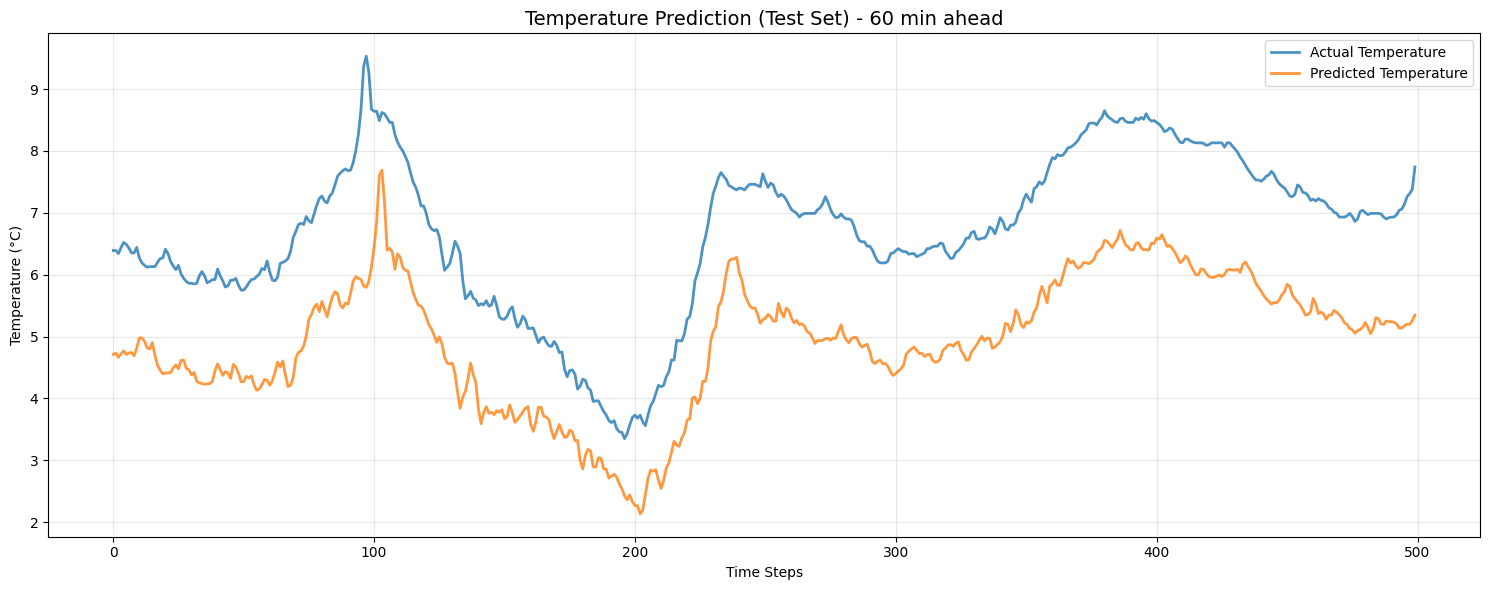

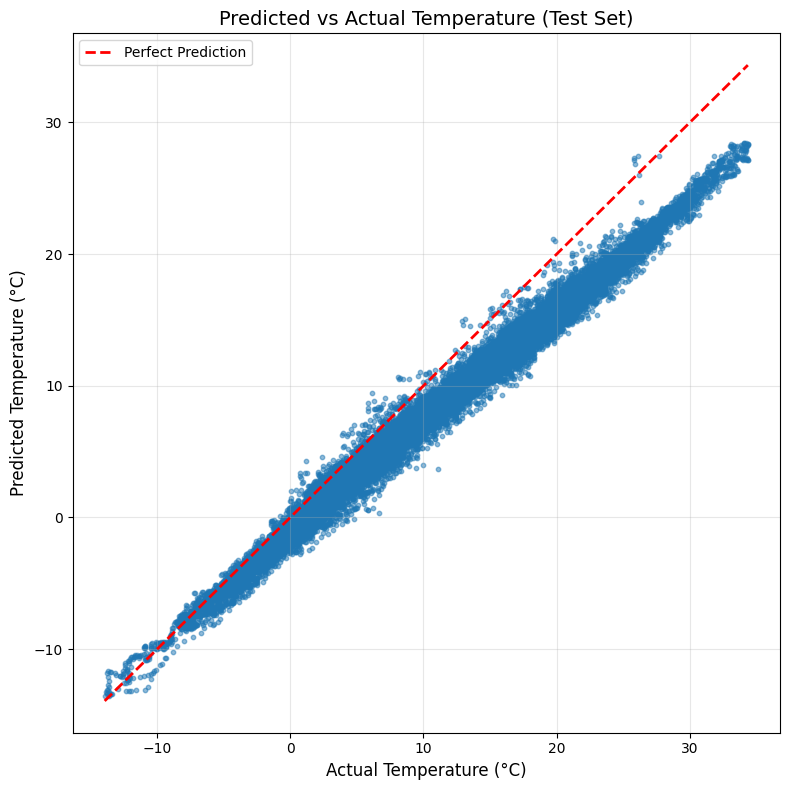

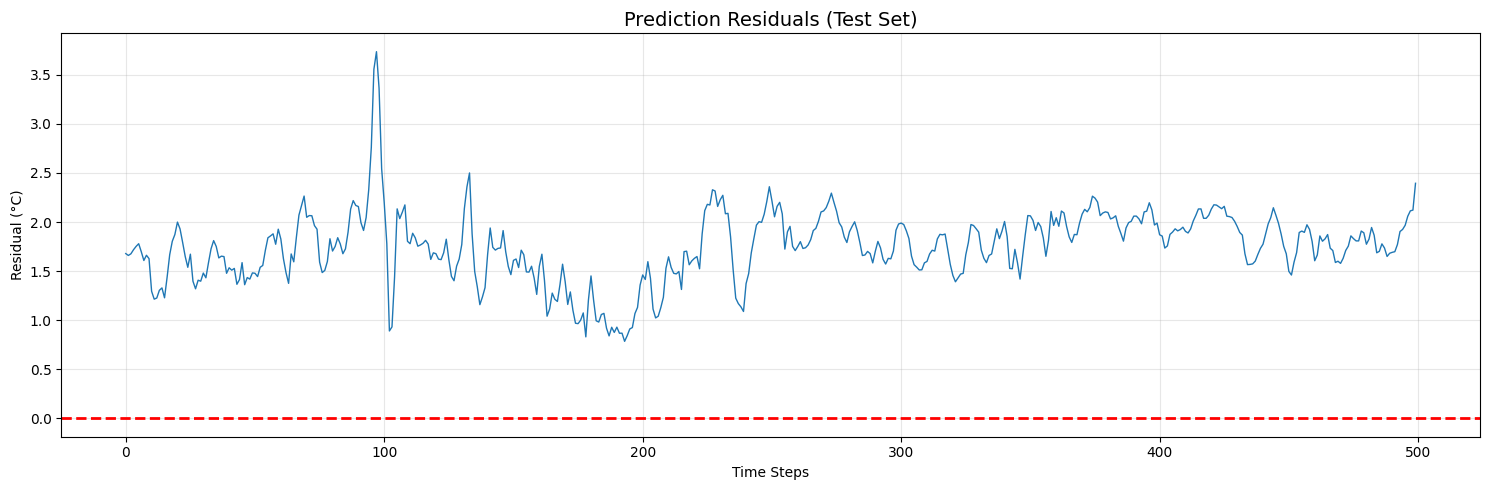

In [16]:
# 11. PREDICTION VISUALIZATION
# ============================================================================

# Plot predictions vs actual for test set
plt.figure(figsize=(15, 6))
plot_range = 500  # Plot first 500 predictions
plt.plot(y_test_actual[:plot_range], label='Actual Temperature', linewidth=2, alpha=0.8)
plt.plot(y_test_predicted[:plot_range], label='Predicted Temperature', linewidth=2, alpha=0.8)
plt.title(f'Temperature Prediction (Test Set) - {FORECAST_HORIZON*10} min ahead', fontsize=14)
plt.xlabel('Time Steps')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Scatter plot: Predicted vs Actual
plt.figure(figsize=(8, 8))
plt.scatter(y_test_actual, y_test_predicted, alpha=0.5, s=10)
plt.plot([y_test_actual.min(), y_test_actual.max()],
         [y_test_actual.min(), y_test_actual.max()],
         'r--', linewidth=2, label='Perfect Prediction')
plt.xlabel('Actual Temperature (°C)', fontsize=12)
plt.ylabel('Predicted Temperature (°C)', fontsize=12)
plt.title('Predicted vs Actual Temperature (Test Set)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Residuals plot
residuals = y_test_actual - y_test_predicted
plt.figure(figsize=(15, 5))
plt.plot(residuals[:plot_range], linewidth=1)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.title('Prediction Residuals (Test Set)', fontsize=14)
plt.xlabel('Time Steps')
plt.ylabel('Residual (°C)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [17]:
# 12. SAVE THE MODEL
# ============================================================================

model.save('jena_climate_lstm_model.h5')
print("✓ Model saved as 'jena_climate_lstm_model.h5'")

# Save scaler for future use
import pickle
with open('temperature_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("✓ Scaler saved as 'temperature_scaler.pkl'")

✓ Model saved as 'jena_climate_lstm_model.h5'
✓ Scaler saved as 'temperature_scaler.pkl'
